<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Interactive Density-based Clustering with DBSCAN 

### Michael J. Pyrcz, Professor, The University of Texas at Austin 

*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

#### DBSCAN Clustering

The DBSCAN (Density-Based Spatial Clustering of Applications with Noise) approach finds clusters of samples (high density) is well suited to working with data with an arbitrary (even non-convex) shape and with noise.

For a complete lecture with linked Python workflows check out:

* [Density-based Clustering Lecture](https://www.youtube.com/watch?v=3GaLe8HaDMc&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=15)

Here's a complete Python workflow and more details DBSCAN:

* [DBSCAN workflow](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb)

The two DBSCAN hyperparameters include:

* **eps** - maximum distance between to samples in features space for a sample to be included in the neighbourhood of the other sample. Too small a value will result in many clusters and outliers, and too large a value will result in one cluster with all the data together.

* **min_samples** - minimum number of samples in a neighbourhood to spawn a new cluster. Use a larger value for noisy data to prevent identifying clusters due to a few outliers.

The method proceeds through the dataset and assigns the samples as:

* **core** point if there are $\ge$ **min_samples** within **eps** distance from the sample

* **border** point if there are $lt$ **min_samples** within **eps** distance from the sample, but the sample is within **eps** distance of a core point.

* **outlier** point if there are $lt$ **min_samples** within **eps** distance from the sample and the sample is not within **eps** distance of a core point

Once the points are assigned these labels, all connected core points and their associate border points are assigned to an unique cluster.  Outlier points are left as outliers without an assigned cluster.  To understand the cluster assigments we should explain the following forms of connection.

**directly density reachable** - point X is directly density reachable from A, if A is a core point and X belongs to the neighborhood (distance $le$ eps) from A.

**density-reachable** - point Y is density reachable from A if Y belongs to a neighborhood of a core point that can reached from A. This would require a chain of core points each belonging the previous core points and the last core point including point Y.

**density-connected** - points A and B are density-connected if there is a point Z that is density-reachable from both points A and B.

**density-based cluster** - a nonempty set where all points are density-connected to eachother. 

The approach iterates as follows:

1. all points are labled as unvisited

2. randomly visit an unvisited sample

3. check if a core point ($ge$ min_sample within eps distance), if so label as core otherwise label as outlier

4. now visit all points within eps distance of the core point, determine if core, otherwise label as border point

5. recusive operation where all points within eps distance of new core points are checked

6. once this is exhausted then randomly visit an unvisited point

This apporach may be thought of as identify and grow/merge clusters guided by local point density.


After some careful interations of these parameters we get the following result.

#### Load and Configure the Required Libraries

The following code loads the required libraries and sets a plotting default.

In [1]:
%matplotlib inline
supress_warnings = False
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from sklearn.model_selection import train_test_split    # train and test split
from sklearn import tree                                # tree program from scikit learn (package for machine learning)
from sklearn import metrics                             # measures to check our models
import scipy.spatial as spatial                         #search for neighbours
from matplotlib.patches import Rectangle                # build a custom legend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import math                                             # sqrt operator
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
cmap = plt.cm.inferno                                   # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                          # grid behind plotting elements
if supress_warnings == True:
    import warnings                                     # supress any warnings for this demonstration
    warnings.filterwarnings('ignore')                  

#### Declare Functions

The following functions for clean code. 

* Just a improved grid for the plot.

In [2]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

#### Recursive Method to Perform DBSCAN 

I wrote this recursive method to perform DBSCAN. Then I used it in the dashboard below.

* Recusursion can be tricky to code so I left my debugging outputs below to demonstrate how this was made and checked.

at point:5, step: 0
[]
step: 1
at point:37, step: 1
[43, 30, 42]
at point:43, step: 2
[37, 30, 14, 42, 62]
at point:30, step: 3
[37, 43, 76, 74]
at point:76, step: 4
[30, 74]
step: 5
at point:74, step: 5
[30, 76, 6]
at point:6, step: 6
[94, 74]
step: 7
step: 7
step: 7
at point:14, step: 7
[67, 43, 42, 62]
at point:67, step: 8
[17, 89, 14]
at point:17, step: 9
[79, 97, 67]
at point:79, step: 10
[66, 17]
step: 11
at point:97, step: 11
[17, 38, 15, 89, 41]
at point:38, step: 12
[91, 97, 15, 41]
at point:91, step: 13
[29, 13, 20, 23, 38]
at point:29, step: 14
[77, 13, 20, 91]
at point:77, step: 15
[29, 13]
step: 16
at point:13, step: 16
[77, 29, 20, 91]
at point:20, step: 17
[29, 13, 91, 23]
at point:23, step: 18
[20, 91]
step: 19
step: 19
step: 19
step: 19
step: 19
at point:15, step: 19
[97, 38, 41, 86]
step: 20
step: 20
step: 20
step: 20
step: 20
step: 20
step: 20
step: 20


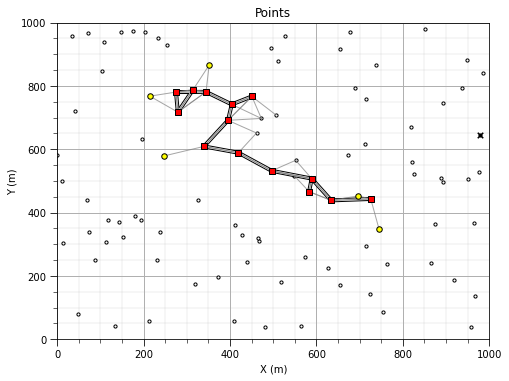

In [7]:
ndata = 100; seed= 13013
np.random.seed(seed=seed)
index = np.arange(0,ndata,1); loc = np.random.rand(ndata,2)*1000; lab = np.zeros(ndata)
visited = np.zeros(ndata)
KDtree = spatial.cKDTree(loc)
plt.scatter(loc[:,0],loc[:,1],marker = 'o',s=10,c='white',edgecolor='black',cmap=plt.cm.inferno)

i = 7; radius = 100; minpts = 4

lab = np.zeros(ndata)

step = 0; maxstep = 20

def search(i,loc,lab,radius,minpts,direct,iprev,step,maxstep):
    if visited[i] == 0 and step < maxstep:
        print('at point:' + str(i) + ', step: ' + str(step))
        visited[i] = 1
        l = KDtree.query_ball_point(loc[i], radius)
        #print('at: ' + str(i) + ', found ' + str(len(l)) + ' points')
        l.remove(i)
        print(l)
        step = step + 1
        if len(l) + 1 >= minpts:
            lab[i] = 2
            plt.scatter(loc[i,0],loc[i,1],s=40,marker='s',c='red',edgecolor='black',cmap=plt.cm.inferno,zorder=100)
            for il in l:
                plt.plot([loc[i,0],loc[il,0]],[loc[i,1],loc[il,1]],color='grey',alpha=0.7,lw=1,zorder=15)
            
            if direct == 0:
                plt.plot([loc[i,0],loc[iprev,0]],[loc[i,1],loc[iprev,1]],color='black',lw=4.0,zorder=10)
                plt.plot([loc[i,0],loc[iprev,0]],[loc[i,1],loc[iprev,1]],color='white',lw=2.0,zorder=13)
            #print('anchor: ' + str(i))
            #print(l)
            for ii in l:
                if step < maxstep:
                    step = search(ii,loc,lab,radius,minpts,0,i,step,maxstep)
        
        else:
            if direct == 0:
                lab[i] = 1
                plt.scatter(loc[i,0],loc[i,1],s=30,c='yellow',edgecolor='black',cmap=plt.cm.inferno,zorder=100)
            elif direct == 1:
                plt.scatter(loc[i,0],loc[i,1],marker='x',s=30,c='black',cmap=plt.cm.inferno)
        print('step: ' + str(step))
    return step
            
while np.sum(visited == 0) > 0 and step < maxstep:
    #print('unvisited remaining: ' + str(np.sum(visited == 0)))
    i = np.random.choice(index[visited == 0],replace=False)  
    step = search(i,loc,lab,radius,minpts,1,-1,step,maxstep)
        
plt.xlim([0,1000]); plt.ylim([0,1000]);plt.xlabel('X (m)');plt.ylabel('Y (m)');plt.title('Points');add_grid()
plt.subplots_adjust(left=0.0,bottom=0.0,right=1.0,top=1.1); plt.show() # set plot size  

### Interactive BDSCAN Dashboard

The following code includes:

* the dashboard with widgets linked to run DBSCAN over a set number of steps for visualization.

In [8]:
l = widgets.Text(value='                                                              Interactive DBSCAN Demo, Prof. Michael Pyrcz, The University of Texas at Austin',
                 layout=Layout(width='890px', height='30px'))

maxstep = widgets.IntSlider(min=1, max = 101, value=10, step = 1, description = '$maxstep$',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
radius = widgets.FloatSlider(min=10, max = 500, value=110, step = 10, description = r'$r$',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
minpts = widgets.IntSlider(min=2, max = 20, value=4, step = 1, description = r'$min_{pts}$',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)

ui = widgets.HBox([maxstep,radius,minpts],)
ui2 = widgets.VBox([l,ui],)

def run_plot(maxstep,radius,minpts):
    ndata = 100; seed= 13013
    np.random.seed(seed=seed)
    index = np.arange(0,ndata,1); loc = np.random.rand(ndata,2)*1000; lab = np.zeros(ndata)
    visited = np.zeros(ndata)
    KDtree = spatial.cKDTree(loc)
    plt.scatter(loc[:,0],loc[:,1],marker = 'o',s=10,c='white',edgecolor='black',cmap=plt.cm.inferno)
    
    step = 0
    def search(i,loc,lab,radius,minpts,direct,iprev,step,maxstep):
        if visited[i] == 0 and step < maxstep:
#             print('at point:' + str(i) + ', step: ' + str(step))
            visited[i] = 1
            l = KDtree.query_ball_point(loc[i], radius)
            #print('at: ' + str(i) + ', found ' + str(len(l)) + ' points')
            l.remove(i)
#             print(l)
            step = step + 1            
            lab[i] = 2
            if len(l) + 1 >= minpts:
                plt.scatter(loc[i,0],loc[i,1],s=40,marker='s',c='red',edgecolor='black',cmap=plt.cm.inferno,zorder=100)
                
                if step > maxstep - 1:
                    for il in l:
                        plt.plot([loc[i,0],loc[il,0]],[loc[i,1],loc[il,1]],color='black',alpha=0.9,lw=1,zorder=15)
                    plt.gca().add_patch(plt.Circle(( loc[i,0] , loc[i,1] ), radius,color='red',fill=False))   
                
                if direct == 0:
                    plt.plot([loc[i,0],loc[iprev,0]],[loc[i,1],loc[iprev,1]],color='black',lw=4.0,zorder=10)
                    plt.plot([loc[i,0],loc[iprev,0]],[loc[i,1],loc[iprev,1]],color='white',lw=2.0,zorder=13)
                #print('anchor: ' + str(i))
                #print(l)
                for ii in l:
                    if step < maxstep:
                        step = search(ii,loc,lab,radius,minpts,0,i,step,maxstep)
            
            else:
                if direct == 0:
                    lab[i] = 1
                    plt.scatter(loc[i,0],loc[i,1],s=30,c='yellow',edgecolor='black',cmap=plt.cm.inferno,zorder=100)
                    plt.plot([loc[i,0],loc[iprev,0]],[loc[i,1],loc[iprev,1]],color='grey',alpha=0.7,lw=1,zorder=15)
                elif direct == 1:
                    plt.scatter(loc[i,0],loc[i,1],marker='x',s=30,c='black',cmap=plt.cm.inferno)
#             print('step: ' + str(step))
        return step
                
    while np.sum(visited == 0) > 0 and step < maxstep:
        #print('unvisited remaining: ' + str(np.sum(visited == 0)))
        i = np.random.choice(index[visited == 0],replace=False)  
        step = search(i,loc,lab,radius,minpts,1,-1,step,maxstep)
            
    plt.xlim([0,1000]); plt.ylim([0,1000]);plt.xlabel('$X_1$');plt.ylabel('$X_2$');plt.title('Interactive Density-based Clustering with BDSCAN');add_grid()
    plt.subplots_adjust(left=0.0,bottom=0.0,right=2.0,top=2.9); plt.show() # set plot size  
        
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(run_plot, {'maxstep':maxstep,'radius':radius,'minpts':minpts})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating  

### Interactive BDSCAN Demonstation 

#### Michael Pyrcz, Professor, The University of Texas at Austin 

Set the radius and minimum number of points and step through the recursive BDSCAN method

### The Inputs

* **maxstep** - recursive steps, **radius** - local neighbourhood, **$min_{pts}$** - minimum number of points

In [5]:
display(ui2, interactive_plot)                           # display the interactive plot

Output()

#### Comments

This was a basic demonstration density-based clustering with BDSCAN. I have many other demonstrations and even basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
#### The Author:

### Michael J. Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  